# Spectral Centroiding and Calibration

If we take a look at a typical a helium emission spectrum, (or any gas for that matter) we would see sharp emission peaks at very distinct wavelengths. This occurs because when atoms are energized (in the case of a helium lamp, by an electric current) they release photons, but they can only do so at several quantized energies (wavelengths). Think of the Bohr model of the atom. An energized electron can drop from the 4th to the 2nd energy level, or the 3rd to 2nd, or the 2nd to 1st, etc. Because those energy levels are quantized, the energies of the photons emitted when an electron falls n levels is also quantized. Every atom has a specific arrangement of electron orbitals that makes it such that the combination of wavelengths it can output due to electron cascading is unique (so a trained spectroscopist can look at almost any emission spectrum and recognize the element!). 

However, when we view spectra like the one we will plot below, we notice that the sharp peaks do in fact have a certain width, despite the description above indicating they should be perfect vertical lines at some defined wavelengths. There are numerous reasons for the widening: spectrometers introduce some widening (instrumental effects), fast moving gas has doppler shifts associated with some photons, and, at a theoretical level, we know from quantum physics that there is always imprecision in either the electron's position or momentum (though this would be a tiny effect in this situation). 

In any case, if we are to perform any sort of scientific analysis on a spectrum, we need to know for each of those peaks what our best guess for the single "right" wavelength for that line should be. One typical method of determining this is centroiding.

**What we will learn** In addition to the basics of actually centroiding a spectrum, this tutorial is meant as a way to practice what we've learned about loops and conditionals, the building blocks of most python code. 

## Quick Background

Centroiding amounts to finding the "center of mass" of a given peak. The formula for determining the centroid of a range of values (such as intensity/signal) is
\begin{equation}
x_{cm} = \frac{\sum x_iI_i}{\sum I_i}.
\end{equation}
where $x_i$ will end up being our wavelength (or pixel number) array, and "I" represents intensity (or Brightness, or # of photons/unit time) at each pixel value. It basically represents a "weighted average" of the peak. Note: we can't simply choose the x value where the peak hits its maximum because the limitations of the spectrometer result in the true "peak value" not lining up with the real wavelength we are looking for. This weighted average of the whole peak provides a better guess. Think about it, just because one extra photon happens to pile into pixel x, doesn't mean pixel x is representitive of that spectral line.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)
#Load up helium spectrum 
pixels = np.loadtxt('week3_helium_spectrum.txt',usecols=(0,)) #take zeroth column
signal = np.loadtxt('week3_helium_spectrum.txt',usecols=(1,)) #take first column

So now we have a pixel and signal array. Our goal is to find the centroid of all the peaks in the plot. Speaking of, let's plot pixels vs signal just to get an idea of what were are looking at:

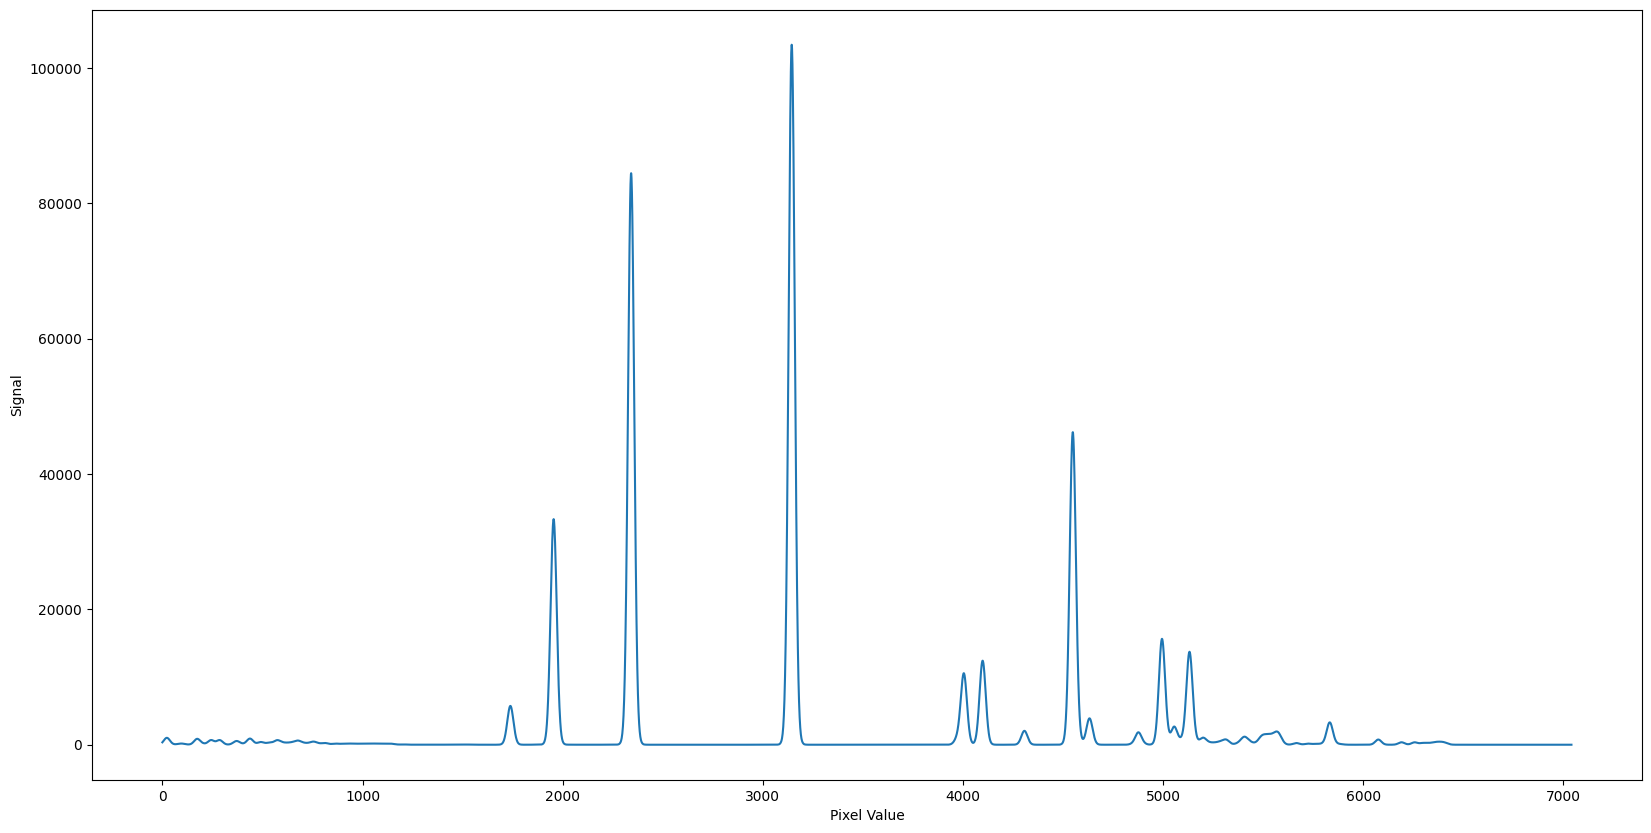

In [2]:
plt.plot(pixels,signal) #fill in what to plot, then run this cell again to see if it matches
plt.xlabel('Pixel Value')
plt.ylabel('Signal')
plt.show()

Notice there are quite a few jitters there. We are only interested in the major features, so when we are performing the following analysis, it would probably be smart to implement some sort of threshold (say, 10,000?) to catch only the major peaks. 

In order to find the centroid of each peak, we need to first determine the peaks in the first place. Let's go ahead and write a peak-finding algorithm. There are many ways to do this, so feel free to try your own. My suggestion is as follows (try it in the space below): 

1. Iterate over a range that's the length of the pixel array (or signal, they're the same length by construction) checking whether each value of signal is higher or lower than the value of signal one to the left and one to the right.
2. If you want to be extra robust, check whether it is in fact higher than its two left and right neighbors. 
3. If it is, call it a peak and append that index where the peak occurs out into a separate array.

I've started the loop for you:

In [3]:
#Find the peaks 

threshold = 10000 #You can just pick slightly lower than the lowest peak you want to centroid
peaks = []    #x positions of the peaks, or rather, their index
for i in range(len(signal)-2): #len(signal)-1 because you will be checking the value after than your last i 
    if (signal[i] > signal[i-1]) and (signal[i] > signal[i+1]) and (signal[i] > threshold) :  #three conditions to be a peak
        if((signal[i] > signal[i-2]) and (signal[i] > signal[i+2])):
            peaks.append(i)

We should now have the positions (in pixel space) where the peaks occur. We now want to calculate the centroid in a region around each peak. This raises a bit of an issue- how wide do we make that region? Too narrow and we don't include the whole peak, too wide and we are biased or influenced by things not actually a part of the peak. 

Turns out, most astronomers' solution to this issue is to use a standardized region known as the Full Width (at) Half Maximum (or FWHM). What this means is we want to use a region that is as wide as where the peak has dropped to half its maximum value. This works well, because the width will automatically be adjusted to handle larger and smaller peaks, and the same "amount" of each peak is being used in our calculation. 


In the space below, iterate over the peaks we just found, and determine the FWHM (in this case it will be very narrow because our spectrometer did not have very high resolution). I suggest defining an xmin and xmax, and using the "np.where" function to search out where the signal array drops below the half max value (easily calculated by taking signal indexed at "i" and dividing by 2). Using that FWHM, caculate the center of mass of each peak, and append the final pixel positions of the centers of mass to a new array/list. Remember that you can sum arrays (and arrays times arrays) without iterating!

In [4]:
centroids = [] #Values for all the centroids
for i in range(len(peaks)):
    #Calculate how far backward and forward to go:
    half_max = signal[peaks[i]]/2
    xmin =  int(pixels[(pixels<=peaks[i])&(signal<=half_max)][-1])
    xmax =  int(pixels[(pixels>=peaks[i])&(signal<=half_max)][0])
    x_range = pixels[xmin:xmax]
    I_range = signal[xmin:xmax]
    x_range = np.array(x_range)
    I_range = np.array(I_range)
    xcm = np.sum(x_range * I_range) / np.sum(I_range)
    centroids.append(xcm) 

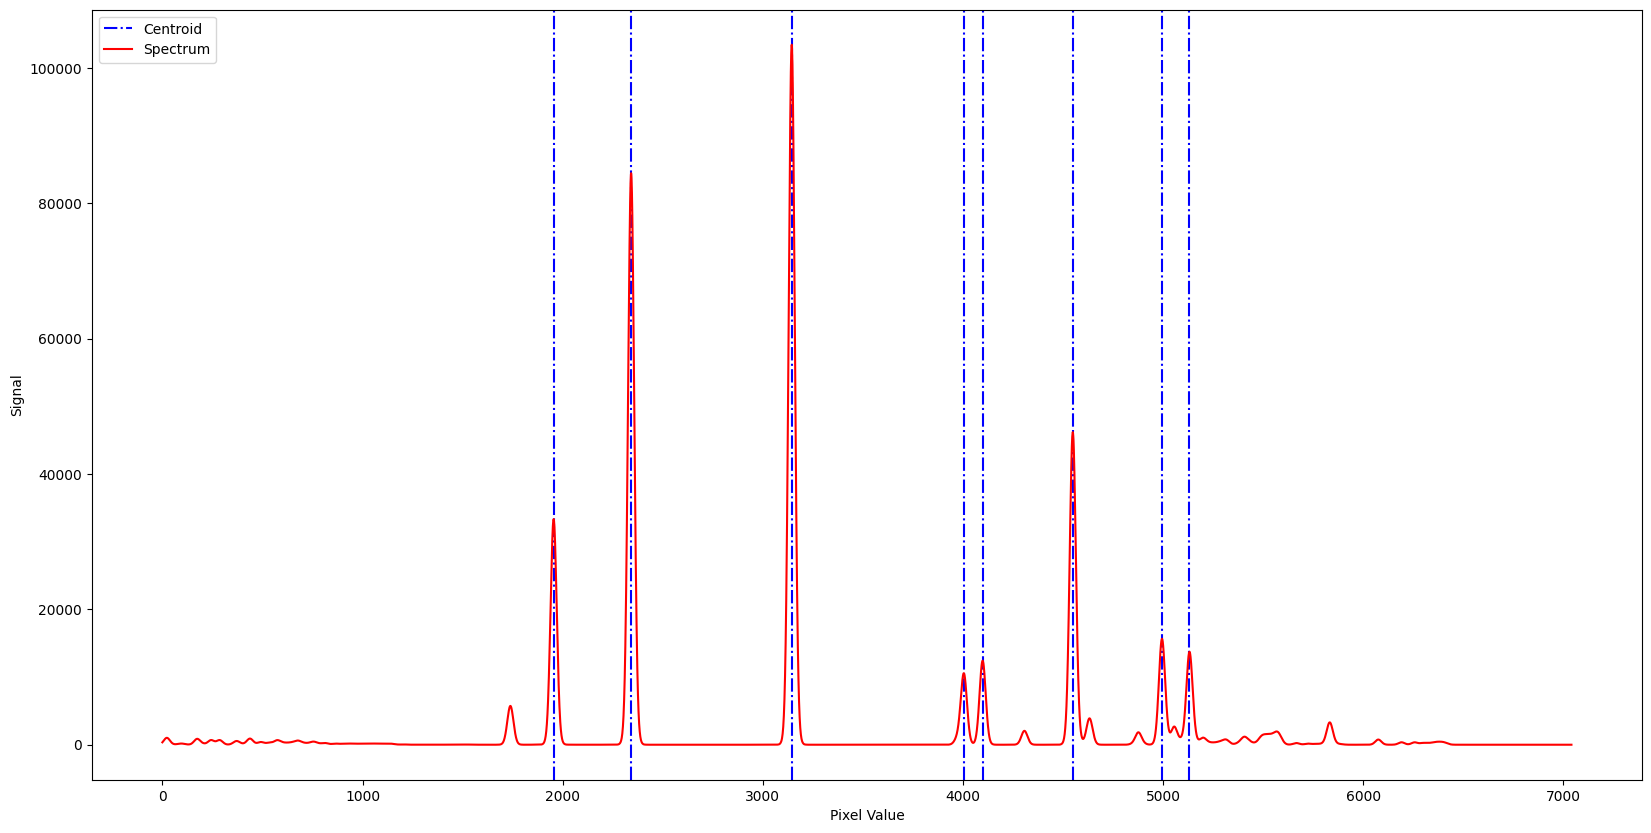

In [5]:
def plot_vert(x): 
    '''
    Just plots vertical lines, in blue dashes
    '''
    plt.axvline(x, color='blue', ls='-.')
    
for i in centroids[1:]: #Call my plotting function on every centroid except the first
    plot_vert(i)
    
plt.axvline(centroids[0],color='blue',ls='-.',label='Centroid') #Reserve the first so I don't have a million "centroid" labels
plt.plot(pixels, signal, 'r', label='Spectrum') #Plot the actual spectrum
plt.xlabel('Pixel Value')
plt.ylabel('Signal')
plt.legend(loc=2)
plt.show() #Show it
#Re-run yourself to replace with your graph and see if it matches

In [6]:
print(centroids)

[1954.3443077987142, 2341.707013132646, 3144.1358728596006, 4003.3387066920054, 4098.079257855311, 4548.250181301581, 4994.487499882394, 5131.590110595172]


## Calibration (or at least setup for that)

Now that we have the pixel locations of the centroids of the lines in our spectrum, the next step is to figure out the calibration --- i.e., we want to find the function that maps the pixel values to physical wavelengths. To do this, you'll want to identify the locations of lines in the real spectrum, which is given in the file `week3_helium_spectrum_wavelength.txt`. Read that spectrum in from the file and plot it below.

In [7]:
# Code to read in spectrum goes here
wavelengths = np.loadtxt('week3_helium_spectrum_wavelength.txt',usecols=(0,)) #take zeroth column
intensities = np.loadtxt('week3_helium_spectrum_wavelength.txt',usecols=(1,)) #take first column

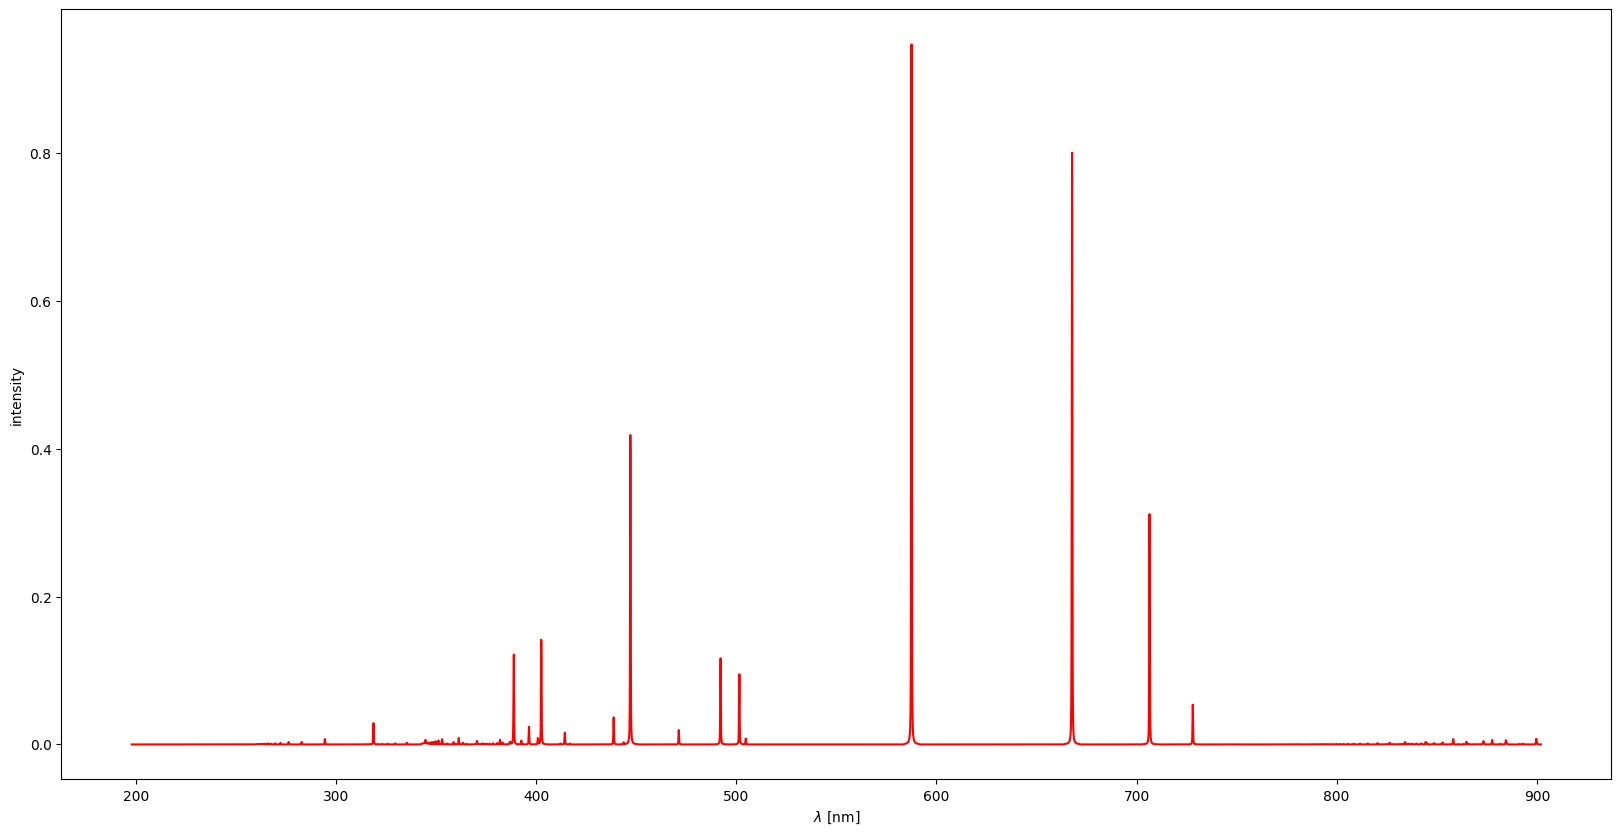

In [8]:
# Fill in the block below to plot the actual spectrum
plt.plot(wavelengths, intensities, 'r') 
plt.xlabel(r'$\lambda\ [{\rm nm}]$')
plt.ylabel('intensity')
plt.show()

You'll notice that it looks similar, but not quite the same as the spectrometer readouts that we've been working with thus far. For example, the lines look more like $\delta$-functions in the real spectrum. Does it look like the lines are in the right places otherwise? Repurpose your code from before to find the wavelength locations of the lines in this spectrum. 

In [9]:
# Block for finding locations of lines
threshold = 0.06 # Choose the threshold value such that you pick out the same peaks here as you did with the spectrometer measurement

peak_wavelengths = []    #x positions of the peaks, or rather, their index
for i in range(len(intensities)-2): #len(signal)-1 because you will be checking the value after than your last i 
    if (intensities[i] > intensities[i-1]) and (intensities[i] > intensities[i+1]) and (intensities[i] > threshold) :  #three conditions to be a peak
        if((intensities[i] > intensities[i-2]) and (intensities[i] > intensities[i+2])):
            peak_wavelengths.append(wavelengths[i])

Plot these wavelengths against the pixel locations of the centroids. What does the relationship look like? Will figuring out this calibration function be easy?

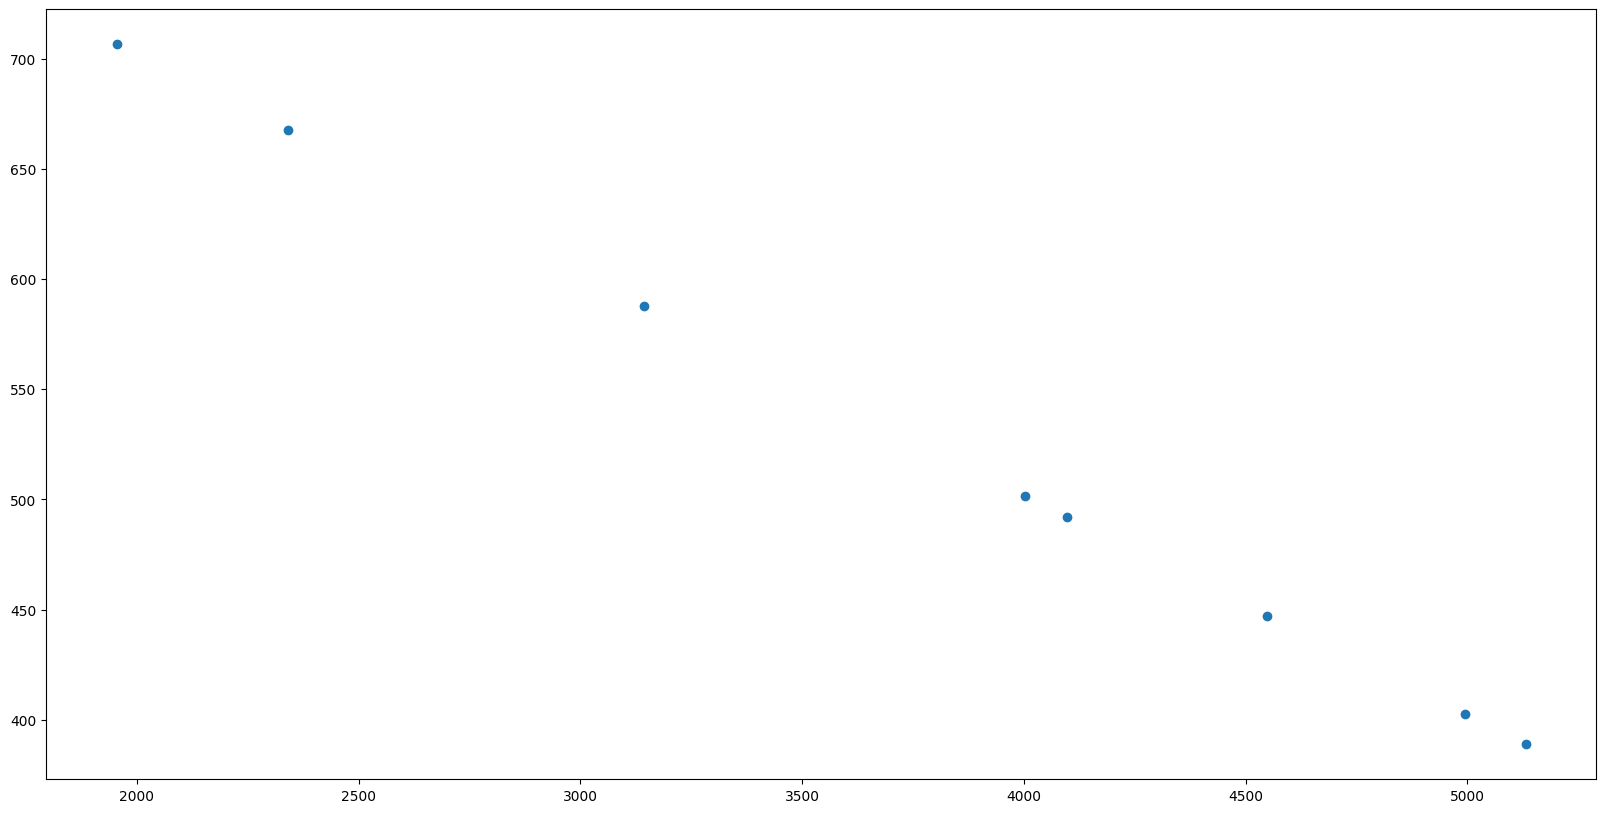

In [10]:
plt.scatter(np.flip(centroids), peak_wavelengths)

Next week, we're going to go through linear regression and understand how we could write code to fit a line to data. We'll use these measurements to find what the calibration between our pixels and wavelengths should be.

## Extra

If you have extra time, let's generate more data. We've included files associated with the spectrometer readout and real spectra for a few other elements; apply your procedure to these and get more points for our line. You might want to think about how you could create a function to clean up your code and make things a bit more systematic...